In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from cbrain.imports import *
from cbrain.data_generator import *

In [3]:
# Use the most promising model
model_path = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B018_purecrm_essv2_nonorm_sample1_max_rs.h5'

In [8]:
data_dir = '/scratch/srasp/preprocessed_data/'
train_pre = 'purecrm_essv2_nonorm_train_sample1_shuffle'
valid_pre = 'purecrm_essv2_nonorm_valid_sample1'
norm_fn = 'purecrm_essv2_nonorm_train_sample1_norm.nc'

In [10]:
train_gen = DataGenerator(data_dir, train_pre+'_features.nc', train_pre+'_targets.nc', 1024, 
                          norm_fn, fsub='feature_means', fdiv='max_rs', tmult='target_conv')

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [11]:
valid_gen = DataGenerator(data_dir, valid_pre+'_features.nc', valid_pre+'_targets.nc', 1024, 
                          norm_fn, fsub='feature_means', fdiv='max_rs', tmult='target_conv',
                          shuffle=False)

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [19]:
model = keras.models.load_model(model_path)

## How sensitive is the model to perturbations in the input data?

inputs : [T_C, Q_C, V_C, dTdt_adiabatic, dQdt_adiabatic, PS, SOLIN]

outputs : [SPDQ, SPDT, QRL, QRS]

In [33]:
# Get f, t from valid
f, t = next(valid_gen.return_generator()); f.shape, t.shape

((1024, 152), (1024, 120))

In [34]:
p = model.predict_on_batch(f)

In [35]:
idx = -1

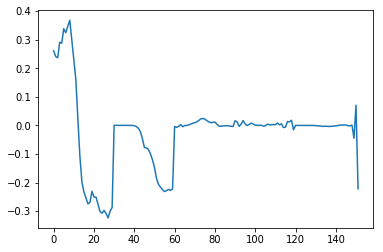

In [36]:
plt.plot(f[idx])

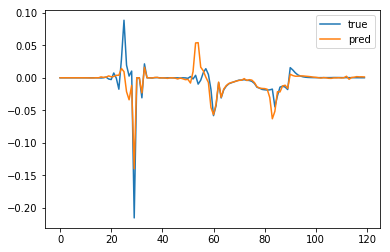

In [37]:
plt.plot(t[idx], label='true'); plt.plot(p[idx], label='pred'); plt.legend();

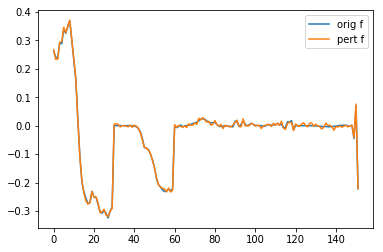

In [68]:
fpert = np.copy(f[idx])
fpert[:] += np.random.normal(0, 0.005, 152)
plt.plot(f[idx], label='orig f'); plt.plot(fpert, label='pert f'); plt.legend();

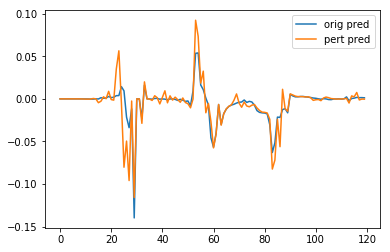

In [69]:
ppert = model.predict_on_batch(fpert[None])
plt.plot(p[idx], label='orig pred'); plt.plot(ppert[idx], label='pert pred'); plt.legend();

### Does adding input noise help?

In [71]:
mnoise = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B020_purecrm_essv2_nonorm_sample1_noise1.h5')

In [73]:
mnoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 139,896
Trainable params: 139,896
Non-trainable params: 0
_________________________________________________________________


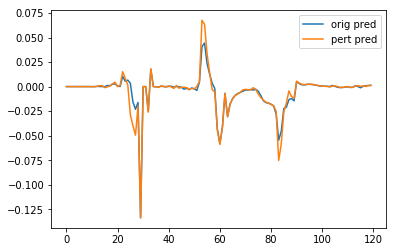

In [77]:
p_noise = mnoise.predict_on_batch(f)
ppert_noise = mnoise.predict_on_batch(fpert[None])
plt.plot(p_noise[idx], label='orig pred'); plt.plot(ppert_noise[idx], label='pert pred'); 
plt.legend();

Yes, definitely makes noisy input predictions smoother. Not sure it is enough but worth a try.

### Does dropout help?

In [78]:
mdrop = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B021_purecrm_essv2_nonorm_sample1_dr1.h5')

In [79]:
mdrop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 139,896
Trainable params: 139,896
Non-trainable params: 0
_________________________________________________________________


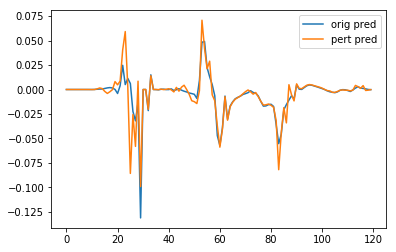

In [80]:
p_drop = mdrop.predict_on_batch(f)
ppert_drop = mdrop.predict_on_batch(fpert[None])
plt.plot(p_drop[idx], label='orig pred'); plt.plot(ppert_drop[idx], label='pert pred'); 
plt.legend();

In [ ]:
# Better dropout?

In [81]:
mdrop = keras.models.load_model('/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/B022_purecrm_essv2_nonorm_sample1_dr2_deep.h5')

In [82]:
mdrop.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               78336     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               61560     
Total params: 402,552
Trainable params: 402,552
Non-trainable params: 0
_________________________________________________________________


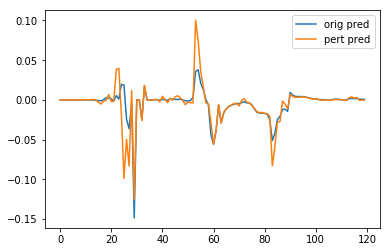

In [83]:
p_drop = mdrop.predict_on_batch(f)
ppert_drop = mdrop.predict_on_batch(fpert[None])
plt.plot(p_drop[idx], label='orig pred'); plt.plot(ppert_drop[idx], label='pert pred'); 
plt.legend();

Dropout doesn't really seem to help with the robustness.